# J = 1 Hamiltonian - Find eigenvalues with VQE algorithm from PartC

# Decomposition of matrices, cross check. Paper decomposition is a different from my algorithm but they describe the same matrix

In [3]:
import numpy as np
from itertools import product

# Define Pauli matrices
I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

# add to lisst
paulis = [I, X, Y, Z]
pauli_labels = ['I', 'X', 'Y', 'Z']

def decompose_matrix(H):
    dim = H.shape[0]
    
    # special case for dim = 2
    if dim == 2:
        tensor_products = paulis
        tensor_product_labels = pauli_labels
    else:
        # create a list of tensor products. Products are sorted for 4 dimensions by II; IX; IY; IZ; XI; XX; XY; XZ...
        tensor_products = [np.kron(p1, p2) for p1, p2 in product(paulis, repeat=int(np.log2(dim)))]
        tensor_product_labels = ['{} ⊗ {}'.format(label1, label2) for label1, label2 in product(pauli_labels, repeat=int(np.log2(dim)))]
    
    # perform the decomposition according to formula
    coefficients = []
    for product_matrix in tensor_products:
        coefficient = np.trace(np.dot(H, product_matrix)) / dim  # Normalize by the dimension of the matrix
        coefficients.append(coefficient)
    
    # Construct the linear combination string
    linear_combination = "H = "
    for coeff, label in zip(coefficients, tensor_product_labels):
        if coeff != 0:
            linear_combination += f"{coeff:.2f} * {label} + "
    
    # Remove the trailing '+' and whitespace
    linear_combination = linear_combination[:-3]
    
    return linear_combination

# define hamiltonians
e = 1; V = 10
H_2x2 = np.array([[-e, -V], [-V, e]])
Hx = 2; Hz = 3; energiesNoninteracting = [0, 2.5, 6.5,7]
H4x4 = np.array([[-2, -np.sqrt(6)*V, 0 , 0],[-np.sqrt(6)*V,0,0,-np.sqrt(6)*V],[0,0,0,0],[0,-np.sqrt(6)*V,0,-2]])

print("Decomposition for 2x2 matrix:")
print(decompose_matrix(H_2x2))

print("\nDecomposition for 4x4 matrix:")
print(H4x4)
print(decompose_matrix(H4x4))
# Crosscheck the decomposition by adding the matrices
H = -1* np.kron(I,I) -1.22*np.kron(I,X) -1.22* np.kron(X,I)+1.22* np.kron(X,Z)-1.22* np.kron(Z,X) -1* np.kron(Z,Z)
print("Decomposition crosscheck: ")
print(H)
print("Paper decomposition:")
H = -(np.kron(Z,I)+ np.kron(I,Z)) - np.sqrt(6)/2 * V *(np.kron(X,I) + np.kron(I,X) + np.kron(Z,X)- np.kron(X,Z))
print(H)

Decomposition for 2x2 matrix:
H = -10.00 * X + -1.00 * Z

Decomposition for 4x4 matrix:
[[ -2.         -24.49489743   0.           0.        ]
 [-24.49489743   0.           0.         -24.49489743]
 [  0.           0.           0.           0.        ]
 [  0.         -24.49489743   0.          -2.        ]]
H = -1.00 * I ⊗ I + -12.25 * I ⊗ X + -12.25 * X ⊗ I + 12.25 * X ⊗ Z + -12.25 * Z ⊗ X + -1.00 * Z ⊗ Z
Decomposition crosscheck: 
[[-2.   -2.44  0.    0.  ]
 [-2.44  0.    0.   -2.44]
 [ 0.    0.    0.    0.  ]
 [ 0.   -2.44  0.   -2.  ]]
Paper decomposition:
[[ -2.         -24.49489743   0.           0.        ]
 [-24.49489743   0.           0.         -24.49489743]
 [  0.           0.           0.           0.        ]
 [  0.         -24.49489743   0.           2.        ]]


# VQE for j = 1

In [29]:
import qiskit as qk
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import numpy as np
from qiskit import transpile
from scipy.optimize import minimize_scalar, minimize

simulator = AerSimulator()

# define a function to create a ansatz wave function
# takes in a quantum circuit, applies the rotation around x by theta and then around y by phi
def ansatz(qc, qr, theta, phi):
    qc.rx(theta, qr[0])
    qc.ry(phi, qr[0])
    return qc
# define a function that makes measurements depending on what Operator should be measured
def measurements(qc, qr, cr, op):
    # measurement of Z operator. Nothing has to be changed, as our measurement basis are eigenstates of the operator
    if op == "Z":        
        # Measurement of qubit 0 on classical register 0
        qc.measure(qr[0],cr[0])
    # Measurement of X operator. Our measurement basis is not eigenstate of X, therfore we have to transform our 
    # measurement states with the Hadamard Gate.
    elif op == "X":
        # Change of basis, since X = HZH
        qc.h(qr[0])
        # Measurement of qubit 0 on classical register 0
        qc.measure(qr[0],cr[0])   
    return qc
# function for getting the energy by evaluating the expectation values of the hamiltonian. The expectation values
# are stored in a dictionary params#
def hamiltonian(params, V):
    # H = -1 X -1 Z
    en = -V*params["X"] - 1*params["Z"]
    return en


def vqe_step(theta, phi,shots, V, verbose = False):
    # Number of executions for each quantum circuit
    
    vqe_res = dict()
    qc_list = dict()
    
    for op in ["X", "Z"]:
        qr = qk.QuantumRegister(1, "qr")
        cr = qk.ClassicalRegister(1, "cr")
        qc = qk.QuantumCircuit(qr, cr)

        # Implementation of the ansatz
        qc = ansatz(qc, qr, theta, phi)

        # Just for plotting purposes
        qc.barrier()

        # Measurements in the appropriate basis (X,Z) are implemented
        qc = measurements(qc, qr, cr, op)
                
        # Get the measurements results
        #counts = qk.execute(qc, simulator, shots=shots).result().get_counts()
        new_circuit = transpile(qc, simulator)
        job = simulator.run(new_circuit, shots = shots)
        counts = job.result().get_counts(qc)
        # Check the results, and evaluate the mean value dividing by the number of shots
        if len(counts) == 1: 
            try:
                counts['0']
                mean_val = 1
            except:
                mean_val = -1
        else:
            # Evaluates the mean value of Z operator, as the difference in the number of 
            # 0s and 1s in the measurement outcomes
            mean_val = (counts['0']-counts['1'])/shots
            
        vqe_res[op] = mean_val
        qc_list[op] = qc
        
    energy = hamiltonian(vqe_res,V)
    
    if verbose: 
        print("Mean values from measurement results:\n", vqe_res) 
        print(f"\n{'Theta':<10} {'Energy':<10} {'<X>':<10} {'<Z>':<10}")
        print(f"{theta:<10f} {energy:<10f} {vqe_res['X']:<10f} {vqe_res['Z']:<10f}")
    
        return energy, qc_list
    
    else: 
        return energy

# Gradient descent for j = 1 and different interaction strengths

Eigenvalue with Numpy:  [-1.41421356  1.41421356]
Doing gradient descent for interactino strength:  0.0
Doing gradient descent for interactino strength:  0.05263157894736842
Doing gradient descent for interactino strength:  0.10526315789473684
Doing gradient descent for interactino strength:  0.15789473684210525
Doing gradient descent for interactino strength:  0.21052631578947367
Doing gradient descent for interactino strength:  0.2631578947368421
Doing gradient descent for interactino strength:  0.3157894736842105
Doing gradient descent for interactino strength:  0.3684210526315789
Doing gradient descent for interactino strength:  0.42105263157894735
Doing gradient descent for interactino strength:  0.47368421052631576
Doing gradient descent for interactino strength:  0.5263157894736842
Doing gradient descent for interactino strength:  0.5789473684210527
Doing gradient descent for interactino strength:  0.631578947368421
Doing gradient descent for interactino strength:  0.68421052631

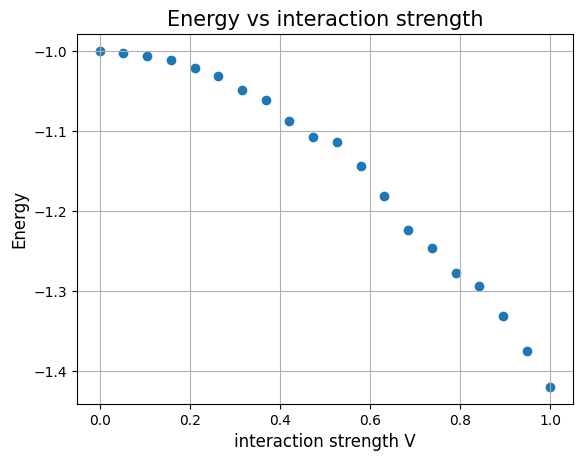

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate Eigenvalues with Pauli Matrices
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.array([[1, 0], [0, 1]])
e = 1; V = 1
H_2x2 = np.array([[-e, -V], [-V, e]])
print("Eigenvalue with Numpy: ", np.linalg.eig(H_2x2)[0])

# Gradient descent parameters
eta = 0.05
Niterations = 60

shots = 10000
# Random angles using uniform distribution
theta = 2 * np.pi * np.random.rand()
phi = 2 * np.pi * np.random.rand()
pi2 = 0.3 * np.pi
# Perform gradient descent
interactionStrengths = np.linspace(0,1,20)
eigenvalues = []
for V in interactionStrengths:
    print("Doing gradient descent for interactino strength: ",V)
    for iter in range(Niterations):
        energies = []
        thetagradient = 1 / (pi2) * (vqe_step(theta + pi2, phi,shots,V) - vqe_step(theta - pi2, phi,shots,V))
        phigradient = 1 / (pi2) * (vqe_step(theta, phi + pi2,shots,V ) - vqe_step(theta, phi - pi2,shots,V))
        theta -= eta * thetagradient
        phi -= eta * phigradient
        energy = vqe_step(theta, phi,shots,V)
        energies.append(energy)
        #print("Iteration:", iter, "Energy:", energy)
    eigenvalues.append(min(energies))
print(eigenvalues)
# Plot the energy values
plt.scatter(interactionStrengths, eigenvalues)
plt.xlabel('interaction strength V', fontsize=12)
plt.ylabel('Energy',fontsize = 12)
plt.title('Energy vs interaction strength', fontsize = 15)
plt.grid(True)
plt.show()

In [31]:
import numpy as np
import plotly.graph_objects as go

resolution = 50
shots = 10000
theta = np.linspace(0, 2*np.pi, resolution)
phi = np.linspace(0, 2*np.pi, resolution)
energies = np.zeros((resolution, resolution))

# Calculate energy values
for i in range(resolution):
    print(i)
    for j in range(resolution):
        energies[i, j] = vqe_step(theta[i], phi[j],1, shots)

# Create 3D plot
fig = go.Figure(data=[go.Surface(z=energies, x=theta, y=phi)])

# Set labels and title
fig.update_layout(scene=dict(
                    xaxis_title='Theta',
                    yaxis_title='Phi',
                    zaxis_title='Energy',
                    ),
                    title='Energy of Hamiltonian')

# Show plot
fig.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


# now for j = 2

In [17]:
import qiskit as qk
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import numpy as np
from qiskit import transpile
from scipy.optimize import minimize_scalar, minimize

simulator = AerSimulator()

"""define a function to create a ansatz wave function
takes in a quantum circuit, applies the rotation around x by theta and then around y by phi """
def ansatz(qc, qr, theta1, theta2, phi1, phi2):
    qc.rx(theta1, qr[0])
    qc.ry(phi1, qr[0])
    qc.rx(theta2, qr[1])
    qc.ry(phi2, qr[1])
    qc.cx(qr[0], qr[1])
    return qc

"""define a function that makes measurements depending on what Operator should be measured"""
def measurements(qc, qr, cr, op):
    # measurement of Z operator. Nothing has to be changed, as our measurement basis are eigenstates of the operator
    if op == "ZZ":        
        # CNOT used to measure ZZ operator
        qc.cx(qr[0],qr[1])
        
        # Measurement of qubit 1 on classical register 0
        qc.measure(qr[0],cr[0])
        qc.measure(qr[1],cr[1])
    # Measurement of X operator. Our measurement basis is not eigenstate of X, therfore we have to transform our 
    # measurement states with the Hadamard Gate.
    elif op == "XI":
        # Operator is H x I
        qc.h(qr[0])
        # Measurement of qubit 1 on classical register 0
        qc.measure(qr[0],cr[0])  
        qc.measure(qr[1],cr[1])
    elif op == "IX":
        # Operator is HxI swap
        qc.swap(qr[0],[qr[1]])
        qc.h(qr[0])
        # Measurement of qubit 1 on classical register 0
        qc.measure(qr[0],cr[0])  
        qc.measure(qr[1],cr[1])
    elif op == "XZ":
        # operator is cnot IxH swap
        qc.swap(qr[0],[qr[1]])
        qc.h(qr[1])
        qc.cx(qr[0],qr[1])
        # Measurement of qubit 1 on classical register 0
        qc.measure(qr[0],cr[0])  
        qc.measure(qr[1],cr[1])
    elif op == "ZX":
        qc.h(qr[1])
        qc.cx(qr[0],qr[1])
        # Measurement of qubit 1 on classical register 0
        qc.measure(qr[0],cr[0])  
        qc.measure(qr[1],cr[1])
    
    return qc

"""function for getting the energy by evaluating the expectation values of the hamiltonian. The expectation values
are stored in a dictionary params """
def hamiltonian(params,V):
    #H = -1.00 * I ⊗ I + -1.22 * I ⊗ X + -1.22 * X ⊗ I + 1.22 * X ⊗ Z + -1.22 * Z ⊗ X + -1.00 * Z ⊗ Z
    en = -1 * 1 -np.sqrt(6)/2*V * (params["IX"] + params["XI"] - params["XZ"] + params["ZX"]) - 1 * params["ZZ"]
    #print(params["ZX"], params["XZ"])
    return en


def vqe_step(theta1, theta2, phi1, phi2,V, verbose = True):
    # Number of executions for each quantum circuit
    shots=10000
    
    vqe_res = dict()
    qc_list = dict()
    
    for op in ["IX", "XI","XZ", "ZX", "ZZ"]:
        qr = qk.QuantumRegister(2, "qr")
        cr = qk.ClassicalRegister(2, "cr")
        qc = qk.QuantumCircuit(qr, cr)

        # Implementation of the ansatz
        qc = ansatz(qc, qr, theta1, theta2, phi1, phi2)

        # Just for plotting purposes
        qc.barrier()

        # Measurements in the appropriate basis (X,Z) are implemented
        qc = measurements(qc, qr, cr, op)
                
        # Get the measurements results
        #counts = qk.execute(qc, simulator, shots=shots).result().get_counts()
        new_circuit = transpile(qc, simulator)
        job = simulator.run(new_circuit, shots = shots)
        counts = job.result().get_counts(qc)
        #print(counts)
        # Check the results, and evaluate the mean value dividing by the number of shots
        try:
            counts["00"]
            c00 = counts["00"]
        except:
            c00 = 0
        try:
            counts["01"]
            c01 = counts["01"]
        except:
            c01 = 0
        try:
            counts["10"]
            c10 = counts["10"]
        except:
            c10 = 0
        try: 
            counts["11"]
            c11 = counts["11"]
        except:
            c11 = 0
        # Evaluates the mean value of Z operator, as the difference in the number of 
        # 0s and 1s in the measurement outcomes
        mean_val = (c00+ c01- c10-c11)/shots
            
        vqe_res[op] = mean_val
        qc_list[op] = qc
        
    energy = hamiltonian(vqe_res,V)
    
    if verbose: 
        print("Mean values from measurement results:\n", vqe_res) 
        print(f"\n{'Theta':<10} {'Energy':<10} {'<X>':<10} {'<Z>':<10}")
        print(f"{theta1:<10f} {energy:<10f} {vqe_res['XX']:<10f} {vqe_res['ZZ']:<10f} {vqe_res['IZ']:<10f} {vqe_res['ZI']:<10f}")
    
        return energy, qc_list
    
    else: 
        return energy

H:  [[-2.         -2.44948974  0.          0.        ]
 [-2.44948974  0.          0.         -2.44948974]
 [ 0.          0.          0.          0.        ]
 [ 0.         -2.44948974  0.         -2.        ]]
Eigenvalue with Numpy:  [ 2.60555128 -2.         -4.60555128  0.        ]
Doing interaction strength now : 0.0
Doing interaction strength now : 0.05263157894736842
Doing interaction strength now : 0.10526315789473684
Doing interaction strength now : 0.15789473684210525
Doing interaction strength now : 0.21052631578947367
Doing interaction strength now : 0.2631578947368421
Doing interaction strength now : 0.3157894736842105
Doing interaction strength now : 0.3684210526315789
Doing interaction strength now : 0.42105263157894735
Doing interaction strength now : 0.47368421052631576
Doing interaction strength now : 0.5263157894736842
Doing interaction strength now : 0.5789473684210527
Doing interaction strength now : 0.631578947368421
Doing interaction strength now : 0.6842105263157894

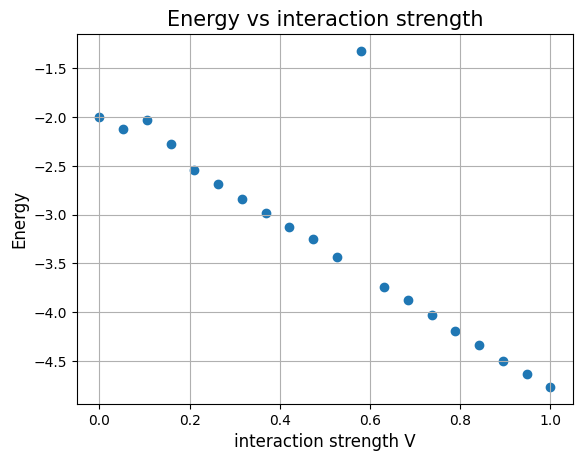

In [26]:
import numpy as np
import matplotlib.pyplot as plt
"""" 

"""
# Calculate Eigenvalues with Pauli Matrices
H = -1* np.kron(I,I) -np.sqrt(6)/2*(np.kron(I,X) +np.kron(X,I)-np.kron(X,Z)+np.kron(Z,X)) -1* np.kron(Z,Z)
print("H: ", H)
print("Eigenvalue with Numpy: ", np.linalg.eig(H)[0])

# Gradient descent parameters
eta = 0.05
Niterations = 60


# Random angles using uniform distribution


pi2 = 0.3 * np.pi
# Perform gradient descent
interactionStrengths4x4 = np.linspace(0,1,20)
eigenvalues4x4 = []
for V in interactionStrengths4x4:
    print("Doing interaction strength now :", V)
    energies = []
    theta1 = 2 * np.pi * np.random.rand(); theta2 = 2 * np.pi * np.random.rand()
    phi1 = 2 * np.pi * np.random.rand(); phi2 = 2 * np.pi * np.random.rand()
    for iter in range(Niterations):
        
        theta1gradient = 1 / (pi2) * (vqe_step(theta1 + pi2, theta2, phi1,phi2,V, False) - vqe_step(theta1 - pi2, theta2, phi1,phi2,V, False))
        theta2gradient = 1 / (pi2) * (vqe_step(theta1 , theta2+ pi2, phi1,phi2,V, False) - vqe_step(theta1 , theta2- pi2, phi1,phi2,V, False))
        phi1gradient = 1 / (pi2) * (vqe_step(theta1 , theta2, phi1+ pi2,phi2,V, False) - vqe_step(theta1 , theta2, phi1- pi2,phi2,V, False))
        phi2gradient = 1 / (pi2) * (vqe_step(theta1 , theta2, phi1,phi2+ pi2,V, False) - vqe_step(theta1 , theta2, phi1,phi2- pi2,V, False))
        theta1 -= eta * theta1gradient
        theta2 -= eta * theta2gradient
        phi1 -= eta * phi1gradient
        phi2 -= eta * phi2gradient
        energy = vqe_step(theta1, theta2, phi1, phi2,V, False)
        energies.append(energy)
        #print("Iteration:", iter, "Energy:", energy)
    eigenvalues4x4.append(min(energies))
print(eigenvalues4x4)


plt.scatter(interactionStrengths4x4, eigenvalues4x4)
plt.xlabel('interaction strength V', fontsize=12)
plt.ylabel('Energy',fontsize = 12)
plt.title('Energy vs interaction strength', fontsize = 15)
plt.grid(True)
plt.show()

In [42]:
import numpy as np
from scipy.optimize import minimize

# Define the function to minimize (energy function)
def energy_function(params):
    theta1, theta2, phi1, phi2 = params
    return vqe_step(theta1, theta2, phi1, phi2, False)

# Initial guess for the angles
initial_guess = [2 * np.pi * np.random.rand(),  # theta1
                 2 * np.pi * np.random.rand(),  # theta2
                 2 * np.pi * np.random.rand(),  # phi1
                 2 * np.pi * np.random.rand()]  # phi2

# Run the Nelder-Mead optimization
result = minimize(energy_function, initial_guess, method='Nelder-Mead')

# Extract the optimal angles and minimum energy
optimal_angles = result.x
minimum_energy = result.fun

print("Optimal Angles (theta1, theta2, phi1, phi2):", optimal_angles)
print("Minimum Energy:", minimum_energy)

Optimal Angles (theta1, theta2, phi1, phi2): [-3.91403313e-02  3.55886196e-03  6.29785751e+00  5.89732101e+00]
Minimum Energy: -4.718787346136434


# plot eigenvalues with numpy and from vqe

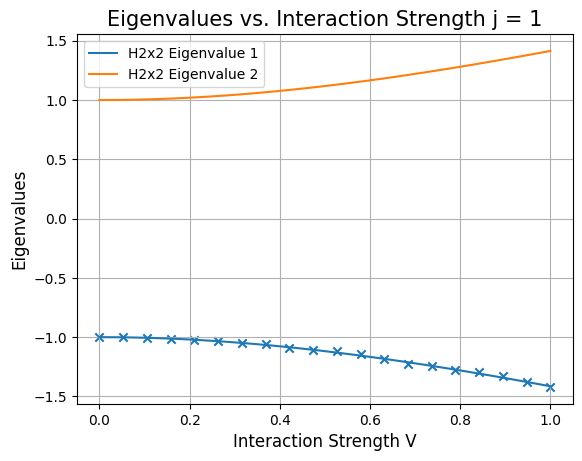

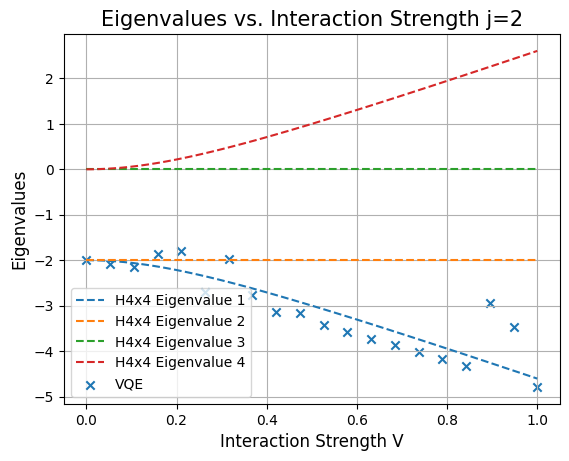

In [27]:
import matplotlib.pyplot as plt
import numpy as np


# Pauli Matrices
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.array([[1, 0], [0, 1]])
e = 1

def H2x2(V):
    return np.array([[-e, -V], [-V, e]])
def H4x4(V):
    return -1* np.kron(I,I) -np.sqrt(6)/2*V*(np.kron(I,X) +np.kron(X,I)-np.kron(X,Z)+np.kron(Z,X)) -1* np.kron(Z,Z)


# Define the range of interaction strength V
V_values = np.linspace(0, 1, 100)  # Adjust the range as needed

# Initialize arrays to store eigenvalues
eigenvalues_H2x2 = []
eigenvalues_H4x4 = []

# Compute eigenvalues for each value of V
for V in V_values:
    # Compute eigenvalues for H2x2
    eigenvalues_H2x2.append(np.linalg.eigvalsh(H2x2(V)))
    
    # Compute eigenvalues for H4x4
    eigenvalues_H4x4.append(np.linalg.eigvalsh(H4x4(V)))

# Convert lists to arrays for easier manipulation
eigenvalues_H2x2 = np.array(eigenvalues_H2x2)
eigenvalues_H4x4 = np.array(eigenvalues_H4x4)

# Plot the eigenvalues as a function of V
#plt.figure(figsize=(10, 6))

# Plot eigenvalues for H2x2
for i in range(len(eigenvalues_H2x2[0])):
    plt.plot(V_values, eigenvalues_H2x2[:, i], label=f'H2x2 Eigenvalue {i+1}')
VVQE = np.linspace(0,1,20)
eigenVQE = [-0.9994, -1.0015789473684211, -1.005536842105263, -1.0112526315789474, -1.0207052631578948, -1.030863157894737, -1.048578947368421, -1.0610526315789475, -1.087242105263158, -1.1066526315789473, -1.1138947368421053, -1.1431368421052632, -1.1804947368421053, -1.2237578947368422, -1.2454736842105263, -1.2768315789473683, -1.2934842105263158, -1.3302842105263157, -1.3747894736842103, -1.4196]
plt.scatter(VVQE, eigenVQE, marker = "x")
plt.xlabel('Interaction Strength V',fontsize = 12)
plt.ylabel('Eigenvalues',fontsize = 12)
plt.title('Eigenvalues vs. Interaction Strength j = 1',fontsize = 15)
plt.legend()
plt.grid(True)
plt.savefig("PartG2x2.png")
plt.show()

#plt.figure(figsize=(10, 6))
# Plot eigenvalues for H4x4
for i in range(len(eigenvalues_H4x4[0])):
    plt.plot(V_values, eigenvalues_H4x4[:, i], linestyle='--', label=f'H4x4 Eigenvalue {i+1}')
VVQE = np.linspace(0,1,20)
eigenVQE = [-2.0, -2.0845572322791908, -2.1601074614837, -1.8674333023399508, -1.8048263087745102, -2.7017266625818754, -1.9810590198778177, -2.7558553020419456, -3.131752305252821, -3.163521006508277, -3.424689763612172, -3.5840543733006522, -3.734209864018662, -3.872379286019113, -4.030825367506456, -4.182539410787528, -4.336038099711145, -2.9465855784615442, -3.4688915794367707, -4.789014018529302]
plt.scatter(VVQE,eigenVQE,label="VQE", marker = "x")
plt.xlabel('Interaction Strength V',fontsize = 12)
plt.ylabel('Eigenvalues',fontsize = 12)
plt.title('Eigenvalues vs. Interaction Strength j=2',fontsize = 15)
plt.legend()
plt.grid(True)
plt.savefig("PartG4x4.png")
plt.show()